In [1]:
!pip install librosa 
!pip install soundfile 

In [6]:
!pip install kaggle

In [7]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
 %cp /content/kaggle.json ~/.kaggle/

In [9]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

 97% 417M/429M [00:04<00:00, 105MB/s]
100% 429M/429M [00:04<00:00, 110MB/s]


In [ ]:
!unzip ravdess-emotional-speech-audio.zip

In [11]:
!mkdir data

In [12]:
!mv A* data

In [18]:
import librosa
import librosa.display
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
import IPython.display as ipd 

from matplotlib.pyplot import specgram
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [19]:
def extract_feature(file_name, mfcc, chroma, mel, tonnetz, contrast):
        X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
        result = np.array([])
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
            result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
        return result

In [20]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
# Emotions to observe
observed_emotions = ['neutral','calm','angry', 'happy','disgust','sad','fearful','surprised']

In [21]:
def load_data():
    X,y=[],[]
    for file in glob.glob('/content/data/Actor_*/*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
       
        # we allow only AVAILABLE_EMOTIONS we set
        if emotion not in observed_emotions:
            continue
       
         # extract speech features
        feature=extract_feature(file, 
                                mfcc=True, 
                                chroma=False, 
                                mel=False, 
                                tonnetz=False, 
                                contrast=False)
    
        X.append(feature)
        y.append(emotion)

    return {"X":X,"y":y}

In [22]:
data = load_data()

In [23]:
X = pd.DataFrame(data["X"])
y = pd.DataFrame(data["y"]) 

In [24]:
# print some details
# number of samples in training data
print("[+] Number of training samples:", X.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", y.shape[0])

[+] Number of training samples: 1440
[+] Number of testing samples: 1440


In [25]:
print(f'Features extracted: {X.shape[1]}')


Features extracted: 40


In [27]:
# Pick a fearful track
fname = '/content/data/Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

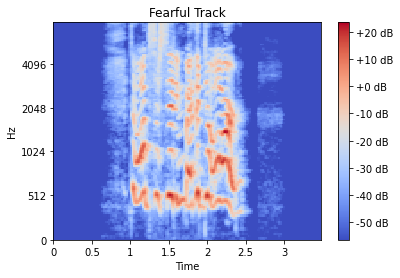

In [28]:
# CREATE LOG MEL SPECTROGRAM
spectrogram = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Fearful Track')
plt.colorbar(format='%+2.0f dB');